# Grad-CAM

可视化模型对图像的关注区域

![image-grad](./grad.png)

<!-- 1. 给定一个图像(属于某个类别),作为输入
2. 通过 `CNN` 的前向传播,得到图像对于某个类别的原始分数
3. 对于除了输入图像的类别其余类别的梯度设置为`0`
4. 将梯度用于反向传播到感兴趣的矫正卷积特征从 -->

- 网络进行正向传播,得到特征层`A`(指最后一个卷积的输出)和网络预测值`y`(softmax函数激活之前),想查看网络对于类别`Tiger cat`的感兴趣区域,假设输出的预测值为:$y^{a}$
- 将$y^{a}$进行反向传播,得到特征层的`A`的梯度信息`A'`,计算针对特征层`A`的每个重要程度
- 加权求和,最后经过`ReLU`得到`Grad-CAM`

通过使用最后一层卷积层的梯度信息来为每个神经元分配重要的值,用于特定感兴趣决策

越往后的特征层抽象程度越高,语义信息越丰富,所以使用特征层的最后一个卷积输出



1. 先计算类别

获取神经元的重要性权重
$$\alpha ^{c}_{k}=\frac{1}{Z}\sum_{i}^{}\sum_{j}\partial \frac{y^{c}}{\partial A^{k}_{ij}} \\\frac{1}{Z}\sum_{i}^{}\sum_{j}=Global Average Pooling$$ 


对于$C$类别的梯度类激活图

$$L^{c}_{Grad-CAM}=ReLU(\sum_{k}\alpha ^{c}_{k}A^{k})$$

In [6]:
import os
os.getcwd()

'/home/yy/FGVC/Grad-CAM'

/home/yy/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


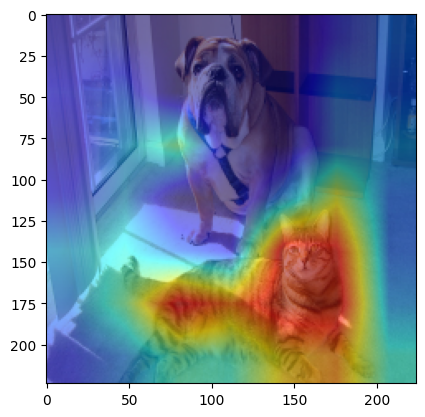

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
import torchvision


model = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
target_layers = [model.features[-1]]  # 传入模块的最后一层
# model = models.resnet34(pretrained=True)
# target_layers = [model.layer4]
# model = models.regnet_y_800mf(pretrained=True)
# target_layers = [model.trunk_output]
# model = models.efficientnet_b0(pretrained=True)
# target_layers = [model.features]
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# load image
img_path = "cat.png"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
img = np.array(img, dtype=np.uint8)
# img = center_crop_img(img, 224)
# [C, H, W]
img_tensor = data_transform(img)
# expand batch dimension
# [C, H, W] -> [N, C, H, W]
input_tensor = torch.unsqueeze(img_tensor, dim=0)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
target_category = 281  # tabby, tabby cat(从0开始所以 -1)
# target_category = 254  # pug, pug-dog
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                  grayscale_cam,
                                  use_rgb=True)
visualization
plt.imshow(visualization)
plt.show()


# 代码阅读

#### 钩子函数

- hook作用:获取变量的中间结果,不使用hook函数Pytorch会自动舍弃图计算的中间结果,在hook函数使用之后要及时删除
- hook两种类别
    - Tensor 级别
        register_hook(hook):为Tensor类型的数据注册一个 backward hook,来获取变量的梯度


In [13]:
import torch
from PIL import Image
import numpy as np

In [2]:
v = torch.tensor([0., 0., 0.], requires_grad=True)
h = v.register_hook(lambda grad: grad * 2)  # double the gradient
v.backward(torch.tensor([1., 2., 3.]))
print(v.grad)
h.remove() # 移除钩子函数

tensor([2., 4., 6.])


- nn.Module 级别
    register_forward/backward_hook(hook):前向传播和反向传播

In [16]:
# 利用钩子函数提取中间层的数据
# features = torch.Tensor() 
# input = torch.ones(1,3,224,224)
# def hook(model,input,output):
#     # 复制中间层数据
#     features.copy_(output.data)
# handel = model.features[20].register_forward_hook(hook)

# model(input.cuda())

# 用完删除
# handel.remove()

In [26]:
# hasattr 对象中包含对应的属性
class test:
    a=100
    b=1
a = test
if hasattr(a,'a'):
    print('success')
else:
    print('None')

success


`np.array` 的图像`shape`格式为`[Height,Width,Channel]`

In [30]:
Img = Image.open('../../Project/image/car.png').convert('RGB')
img_np = np.array(img)
print(img_np.shape)

(224, 224, 3)
